# Objective:
Predict whether players observed by scouts are average or highlighted based on the attribute scores assigned to them during matches.
The dataset comes from Scoutium, containing player evaluations made by scouts during games. It includes attributes observed in the match and the final potential labels given by scouts.

# Datasets
1. scoutium_attributes.csv
8 variables, 10,730 observations
Contains attribute-based evaluations for each player in a match.


| Variable         | Description                                                  |
| ---------------- | ------------------------------------------------------------ |
| task_response_id | Set of all evaluations a scout made for the squad in a match |
| match_id         | ID of the match                                              |
| evaluator_id     | ID of the scout                                              |
| player_id        | ID of the evaluated player                                   |
| position_id      | Player’s position in the match                               |
| analysis_id      | Set of attribute scores assigned to a player by a scout      |
| attribute_id     | ID of the evaluated attribute                                |
| attribute_value  | Score given to a specific attribute                          |


position_id mapping
Goalkeeper
Centre-back
Right-back
Left-back
Defensive midfielder
Central midfielder
Right winger
Left winger
Attacking midfielder
Striker


2. scoutium_potential_labels.csv
5 variables, 322 observations
Contains the scout's final decision about each player’s potential (target variable).

| Variable         | Description                                        |
| ---------------- | -------------------------------------------------- |
| task_response_id | Set of evaluations by a scout in a match           |
| match_id         | Match ID                                           |
| evaluator_id     | Scout ID                                           |
| player_id        | Player ID                                          |
| potential_label  | Final potential label given to the player (target) |


# Tasks
# Step 1:
Read the scoutium_attributes.csv and scoutium_potential_labels.csv files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)


pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Step 1: Load the CSV datasets
import pandas as pd

# Step 1: Load the CSV datasets with correct separator
attributes = pd.read_csv("/kaggle/input/scoutium/scoutium_attributes.csv", sep=";")
potential_labels = pd.read_csv("/kaggle/input/scoutium/scoutium_potential_labels.csv", sep=";")

print("Attributes Shape:", attributes.shape)
print("Potential Labels Shape:", potential_labels.shape)

attributes.head()
potential_labels.head()




Attributes Shape: (10730, 8)
Potential Labels Shape: (322, 5)


,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


# Step 2:
Merge the two datasets using the following four keys:
"task_response_id"
"match_id"
"evaluator_id"
"player_id"

In [3]:
# Step 2: Merge the two datasets
df = pd.merge(
    attributes,
    potential_labels,
    on=["task_response_id", "match_id", "evaluator_id", "player_id"],
    how="inner"
)

print("Merged Data Shape:", df.shape)
df.head()


Merged Data Shape: (10730, 9)


,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


# Step 3:
Remove the Goalkeeper class (position_id = 1) from the dataset.

In [4]:
# Step 3: Remove goalkeeper class (position_id = 1)
df = df[df["position_id"] != 1].copy()

print("Shape after removing goalkeepers:", df.shape)
df["position_id"].value_counts()


Shape after removing goalkeepers: (10030, 9)


position_id
2     1972
6     1428
10    1088
8     1020
7      986
3      986
4      884
9      850
5      816
Name: count, dtype: int64

# Step 4:
Remove the below_average class from potential_label.
(This class represents only 1% of the entire dataset.)

In [5]:
# Step 4: Remove the "below_average" class
df = df[df["potential_label"] != "below_average"].copy()

print("Shape after removing below_average:", df.shape)
df["potential_label"].value_counts()


Shape after removing below_average: (9894, 9)


potential_label
average        7922
highlighted    1972
Name: count, dtype: int64

# Step 5:
Create a pivot table so that each row represents a single player.
Pivot Table Structure:
Index: "player_id", "position_id", "potential_label"
Columns: "attribute_id"
Values: "attribute_value"
Example structure:
| player_id | position_id | potential_label | 4322 | 4323 | 4324 | ... |
| --------- | ----------- | --------------- | ---- | ---- | ---- | --- |
| 1355710   | 7           | average         | 50.5 | 50.5 | 34.0 | ... |
| 1356362   | 9           | average         | 67.0 | 67.0 | 67.0 | ... |
| 1356375   | 3           | average         | 67.0 | 67.0 | 67.0 | ... |
| ...       | ...         | ...             | ...  | ...  | ...  |     |


In [6]:
# Step 5: Create pivot table
pivot_df = df.pivot_table(
    index=["player_id", "position_id", "potential_label"],
    columns="attribute_id",
    values="attribute_value",
    aggfunc="mean"     # aynı attribute_id tekrar ederse ortalama alınsın
)

pivot_df.head()


attribute_id                            4322   4323   4324   4325   4326  \
player_id position_id potential_label                                      
1355710   7           average         50.500 50.500 34.000 50.500 45.000   
1356362   9           average         67.000 67.000 67.000 67.000 67.000   
1356375   3           average         67.000 67.000 67.000 67.000 67.000   
          4           average         67.000 78.000 67.000 67.000 67.000   
1356411   9           average         67.000 67.000 78.000 78.000 67.000   

attribute_id                            4327   4328   4329   4330   4332  \
player_id position_id potential_label                                      
1355710   7           average         45.000 45.000 45.000 50.500 56.000   
1356362   9           average         67.000 67.000 67.000 67.000 67.000   
1356375   3           average         67.000 67.000 78.000 67.000 67.000   
          4           average         78.000 78.000 78.000 56.000 67.000   
1356411   9           average         67.000 67.000 67.000 89.000 78.000   

attribute_id                            4333   4335   4338   4339   4340  \
player_id position_id potential_label                                      
1355710   7           average         39.500 34.000 39.500 39.500 45.000   
1356362   9           average         67.000 67.000 67.000 67.000 67.000   
1356375   3           average         78.000 56.000 67.000 67.000 67.000   
          4           average         67.000 67.000 78.000 78.000 56.000   
1356411   9           average         67.000 67.000 67.000 56.000 56.000   

attribute_id                            4341   4342   4343   4344   4345  \
player_id position_id potential_label                                      
1355710   7           average         45.000 50.500 28.500 23.000 39.500   
1356362   9           average         67.000 67.000 67.000 56.000 67.000   
1356375   3           average         67.000 67.000 56.000 56.000 67.000   
          4           average         67.000 67.000 45.000 45.000 56.000   
1356411   9           average         67.000 78.000 56.000 56.000 67.000   

attribute_id                            4348   4349   4350   4351   4352  \
player_id position_id potential_label                                      
1355710   7           average         28.500 28.500 45.000 50.500 56.000   
1356362   9           average         67.000 56.000 67.000 67.000 67.000   
1356375   3           average         67.000 56.000 56.000 67.000 67.000   
          4           average         67.000 67.000 67.000 67.000 78.000   
1356411   9           average         56.000 67.000 56.000 67.000 67.000   

attribute_id                            4353   4354   4355   4356   4357  \
player_id position_id potential_label                                      
1355710   7           average         34.000 39.500 50.500 34.000 34.000   
1356362   9           average         67.000 78.000 67.000 67.000 67.000   
1356375   3           average         67.000 78.000 67.000 67.000 67.000   
          4           average         67.000 67.000 67.000 56.000 67.000   
1356411   9           average         56.000 67.000 67.000 56.000 67.000   

attribute_id                            4407   4408   4423   4426  
player_id position_id potential_label                              
1355710   7           average         56.000 34.000 34.000 56.000  
1356362   9           average         67.000 67.000 56.000 78.000  
1356375   3           average         67.000 67.000 56.000 78.000  
          4           average         56.000 67.000 45.000 56.000  
1356411   9           average         89.000 56.000 67.000 78.000

 Step 5.1:
Use reset_index() to convert the index back into columns and convert the "attribute_id" column names into strings.

In [7]:
# Reset index (convert index to columns)
pivot_df = pivot_df.reset_index()

# Convert attribute_id column names to strings
pivot_df.columns = pivot_df.columns.map(str)

pivot_df.head()


attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [8]:

# 2) PIVOT TABLE
pivot_df = df.pivot_table(
    index=["player_id", "position_id", "potential_label"],
    columns="attribute_id",
    values="attribute_value",
    aggfunc="mean"
).reset_index()

pivot_df.columns = pivot_df.columns.astype(str)

# 3) X ve y'yi TANIMLA
X = pivot_df.drop("potential_label", axis=1)
y = pivot_df["potential_label"]

print("X shape:", X.shape)
print("y shape:", y.shape)




X shape: (271, 36)
y shape: (271,)


# Step 6:
Apply Label Encoding to the "potential_label" variable (average → 0, highlighted → 1).

In [9]:
from sklearn.preprocessing import LabelEncoder

# Step 6: Label Encoding for potential_label
le = LabelEncoder()
pivot_df["potential_label"] = le.fit_transform(pivot_df["potential_label"])

pivot_df["potential_label"].value_counts()

X = pivot_df.drop("potential_label", axis=1)
y = pivot_df["potential_label"]



# Step 7:
Store all numeric variable names in a list named num_cols.

In [10]:
# Step 7: Select numerical columns
num_cols = pivot_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Number of numerical columns:", len(num_cols))
print(num_cols[:10])  


Number of numerical columns: 37
['player_id', 'position_id', 'potential_label', '4322', '4323', '4324', '4325', '4326', '4327', '4328']


# Step 8:
Apply StandardScaler to all variables in num_cols.

In [11]:
from sklearn.preprocessing import StandardScaler

# Step 8: Scale numerical columns (except the target variable)
num_cols = [col for col in num_cols if col != "potential_label"]

scaler = StandardScaler()
pivot_df[num_cols] = scaler.fit_transform(pivot_df[num_cols])

pivot_df.head()


attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,-0.892,0.511,0,-0.543,-0.559,-1.405,-0.438,-0.767,-0.795,-0.907,-0.792,-0.446,-0.123,-1.224,-1.036,-1.126,-1.009,-0.542,-0.690,-0.535,-1.067,-1.206,-1.005,-1.314,-1.042,-0.693,-0.436,0.013,-1.282,-1.132,-0.495,-1.235,-1.520,-0.143,-1.487,-0.955,-0.253
1,-0.888,1.256,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,0.404,0.728,0.691,0.459,0.996,0.632,0.840,0.912,0.799,0.588,1.230,0.750,0.742,0.879,0.670,0.848,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
2,-0.888,-0.979,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,1.002,0.728,0.691,1.132,0.319,0.632,0.840,0.912,0.799,0.588,0.574,0.750,0.742,0.879,0.670,0.077,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
3,-0.888,-0.606,0,0.595,1.308,0.679,0.683,0.723,1.482,1.355,1.002,-0.055,0.691,0.459,0.996,1.335,1.580,0.185,0.799,0.588,-0.083,0.098,0.043,0.879,1.355,0.848,0.717,1.560,0.814,0.428,0.632,0.198,0.768,-0.143,0.669,-0.276,-0.253
4,-0.888,1.256,0,0.595,0.561,1.373,1.430,0.723,0.723,0.601,0.404,2.294,1.505,0.459,0.996,0.632,0.101,0.185,0.799,1.337,0.574,0.750,0.742,0.252,1.355,0.077,0.717,0.787,0.115,0.428,0.632,0.198,0.768,1.874,-0.050,1.083,1.042


# Step 9:
Build a machine learning model that predicts the players’ potential label with minimum error.
Print the following performance metrics:
ROC_AUC
F1 Score
Precision
Recall
Accuracy

In [12]:
# ===========================
# 1) IMPORTS
# ===========================

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# ===========================
# 2) FUNCTION DEFINITION
# ===========================

def base_models(X, y, scoring="roc_auc"):
    print("Base Models ...")
    
    classifiers = [
        ('LR', LogisticRegression(max_iter=500)),
        ('KNN', KNeighborsClassifier()),
        ('SVC', SVC(probability=True)),
        ('CART', DecisionTreeClassifier()),
        ('RF', RandomForestClassifier()),
        ('Adaboost', AdaBoostClassifier()),
        ('GBM', GradientBoostingClassifier()),
        ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric="logloss")),
        ('CatBoost', CatBoostClassifier(verbose=False, loss_function="Logloss"))
    ]

    for name, classifier in classifiers:
        cv_results = cross_validate(
            classifier, X, y, cv=3, scoring=scoring, n_jobs=-1
        )
        print(f"{name}: {scoring} = {round(cv_results['test_score'].mean(), 4)}")





In [13]:

# PARAMETER GRIDS


knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11]
}

cart_params = {
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_split": [2, 5, 10, 20]
}

rf_params = {
    "max_depth": [6, 8, 12, None],
    "max_features": [5, 7, "sqrt"],
    "min_samples_split": [5, 10, 15],
    "n_estimators": [200, 300, 400]
}

xgboost_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "n_estimators": [100, 200, 300],
    "colsample_bytree": [0.5, 0.7, 1]
}


catboost_params = {
    "depth": [4, 6],
    "learning_rate": [0.03],
    "iterations": [200]
}


classifiers = [
    ("KNN", KNeighborsClassifier(), knn_params),
    ("CART", DecisionTreeClassifier(), cart_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric="logloss"), xgboost_params),
    ("CatBoost", CatBoostClassifier(verbose=0), catboost_params)
]


#  PIPELINE FUNCTION


def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    results = []
    best_models = {}

    print("\nHyperparameter Optimization Started...\n")

    for name, model, params in classifiers:
        print(f"→ Tuning {name} ...")

        gs = GridSearchCV(
            estimator=model,
            param_grid=params,
            cv=cv,
            n_jobs=-1,
            scoring=scoring,
            verbose=0
        )

        gs.fit(X, y)
        best_model = gs.best_estimator_
        best_score = gs.best_score_

        results.append((name, best_score))
        best_models[name] = best_model

        print(f"   Best ROC-AUC: {best_score:.4f}")
        print(f"   Best Params : {gs.best_params_}\n")

    # En iyi modeli bul
    best_model_name, best_score = sorted(results, key=lambda x: x[1], reverse=True)[0]
    print("===================================================")
    print(f"🎉 Best model: {best_model_name}  (ROC-AUC: {best_score:.4f})")
    print("===================================================")

    return best_model_name, best_models[best_model_name], results


# RUN PIPELINE


best_model_name, best_model, results = hyperparameter_optimization(X, y)

print("\nAll Model Results (ROC-AUC):")
for name, score in results:
    print(f"{name}: {score:.4f}")

print("\nFinal Best Model:", best_model_name)



Hyperparameter Optimization Started...

→ Tuning KNN ...
   Best ROC-AUC: 0.5088
   Best Params : {'n_neighbors': 7}

→ Tuning CART ...
   Best ROC-AUC: 0.8155
   Best Params : {'max_depth': 8, 'min_samples_split': 20}

→ Tuning RF ...
   Best ROC-AUC: 0.9084
   Best Params : {'max_depth': 8, 'max_features': 7, 'min_samples_split': 5, 'n_estimators': 400}

→ Tuning XGBoost ...
   Best ROC-AUC: 0.8838
   Best Params : {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}

→ Tuning CatBoost ...
   Best ROC-AUC: 0.8879
   Best Params : {'depth': 6, 'iterations': 200, 'learning_rate': 0.03}

🎉 Best model: RF  (ROC-AUC: 0.9084)

All Model Results (ROC-AUC):
KNN: 0.5088
CART: 0.8155
RF: 0.9084
XGBoost: 0.8838
CatBoost: 0.8879

Final Best Model: RF


# Step 10:
Use a feature_importance function to visualize the importance ranking of the variables.

In [14]:
# 1) X ve y
X = pivot_df.drop("potential_label", axis=1)
y = pivot_df["potential_label"]

# 2) Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y
)

# 3) Random Forest modelini oluştur ve eğit
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# 4) Feature Importance DataFrame'i oluştur
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# 5) İlk 20 feature'ı göster
importance_df.head(20)



,Feature,Importance
5,4325,0.119
6,4326,0.070
17,4341,0.057
20,4344,0.043
0,player_id,0.043
24,4350,0.041
15,4339,0.034
25,4351,0.032
14,4338,0.032
21,4345,0.031


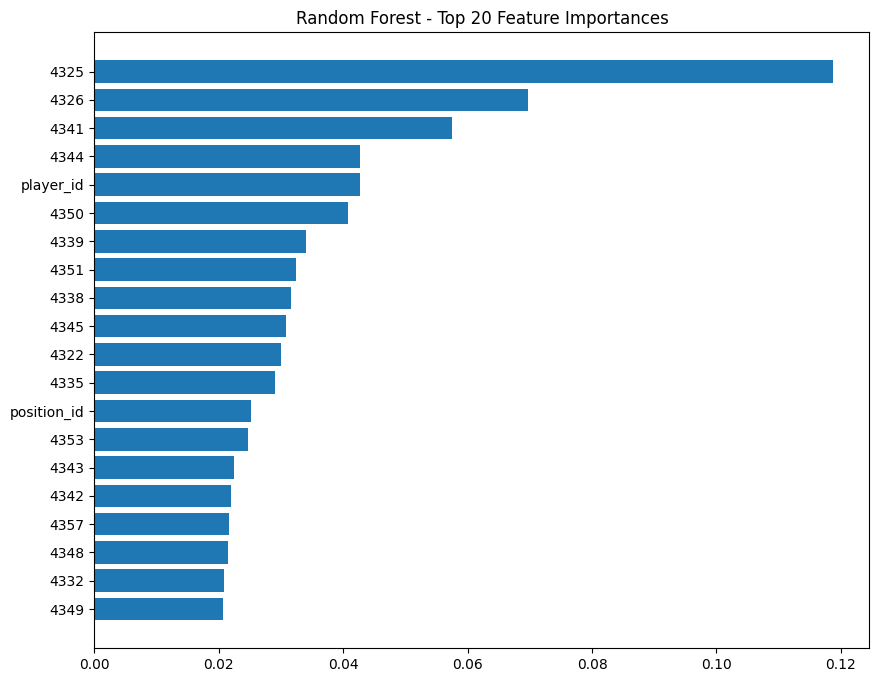

In [15]:
import matplotlib.pyplot as plt

top_20 = importance_df.head(20)

plt.figure(figsize=(10, 8))
plt.barh(top_20["Feature"], top_20["Importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest - Top 20 Feature Importances")
plt.show()



In [16]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    rf, X, y,
    scoring="accuracy",
    cv=skf,
    n_jobs=-1
)

print("CV Mean Accuracy:", cv_scores.mean())
print("CV Scores:", cv_scores)


CV Mean Accuracy: 0.8707744107744106
CV Scores: [0.89090909 0.90740741 0.83333333 0.88888889 0.83333333]
